In [25]:
import fastbook 
fastbook.setup_book()

In [26]:
from fastai.vision.all import *
import os
path=Path()

In [27]:
df=pd.read_csv("F:/Deep Learning/FastAI/FastAI2/FacialAge2/train.csv")
df

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE
...,...,...
19901,2482.jpg,MIDDLE
19902,20085.jpg,YOUNG
19903,19663.jpg,MIDDLE
19904,10132.jpg,MIDDLE


In [28]:
dblock=DataBlock()

In [29]:
dsets=dblock.datasets(df)

In [30]:
len(dsets.train),len(dsets.valid)

(15925, 3981)

In [31]:
x,y=dsets.train[0]
x,y

(ID       10153.jpg
 Class       MIDDLE
 Name: 15999, dtype: object,
 ID       10153.jpg
 Class       MIDDLE
 Name: 15999, dtype: object)

In [32]:
x['ID']

'10153.jpg'

In [33]:
# path=Path('Train/FacialAge2/Train')
# fns=get_image_files(path)
# fns

In [34]:
# for fn in fns:
#     passed=verify_image(fn)
#     if not passed:
#         os.unlink(fn)

In [35]:
dblock=DataBlock(get_x=lambda r:r['ID'],get_y=lambda r: r['Class'])
dsets=dblock.datasets(df)
dsets.train[0]

('14082.jpg', 'MIDDLE')

In [36]:
def get_x(r): return r['ID']
def get_y(r): return r['Class']
dblock=DataBlock(get_x=get_x,get_y=get_y)
dsets=dblock.datasets(df)
dsets.train[0]

('24265.jpg', 'OLD')

In [37]:
def get_x(r): return path/'FacialAge2'/'Train'/r['ID']
def get_y(r): return r['Class']
dblock=DataBlock(get_x=get_x,get_y=get_y)
dsets=dblock.datasets(df)
dsets.train[0]

(Path('FacialAge2/Train/208.jpg'), 'YOUNG')

In [38]:
dblock=DataBlock(blocks=(ImageBlock,CategoryBlock),
                get_x=get_x,get_y=get_y)
dsets=dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=28x38, TensorCategory(1))

In [39]:
dblock=DataBlock(blocks=(ImageBlock,CategoryBlock),
                splitter=RandomSplitter(valid_pct=0.2,seed=42),
                get_x=get_x,
                get_y=get_y,
                item_tfms=RandomResizedCrop(128,min_scale=0.35))
dls=dblock.dataloaders(df)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


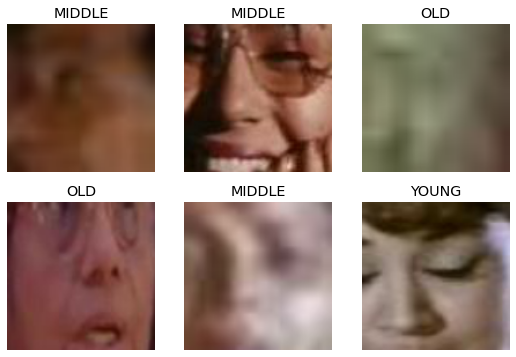

In [40]:
dls.show_batch(nrows=2,ncols=3)

# Creating Neural Network

In [41]:
def get_data(presize,resize):
    return DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    item_tfms=Resize(presize),
    batch_tfms=[*aug_transforms(min_scale=0.5,size=resize),
               Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(df,bs=15)

In [42]:
dls=get_data(160,128)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


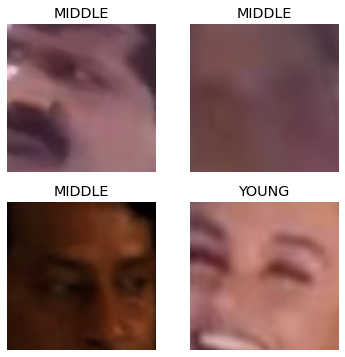

In [43]:
dls.show_batch(max_n=4)

In [44]:
def block(ni,nf): return ConvLayer(ni,nf,stride=2)
def get_model():
    return nn.Sequential(
    block(3,16),
    block(16,32),
    block(32,64),
    block(64,128),
    block(128,256),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(256,dls.c))

In [45]:
def get_learner(m):
    return Learner(dls,m,loss_func=nn.CrossEntropyLoss(),metrics=accuracy)
learn=get_learner(get_model())

SuggestedLRs(valley=0.0002754228771664202)

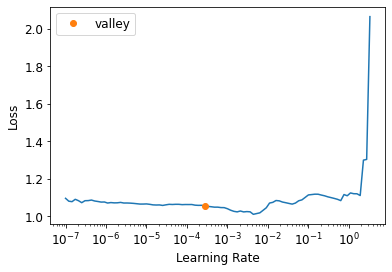

In [46]:
learn.lr_find()

In [47]:
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.919939,0.856608,0.607134,00:48
1,0.843777,0.811961,0.641296,00:47
2,0.784115,0.768152,0.659633,00:48
3,0.730437,0.715300,0.690279,00:47
4,0.751188,0.712137,0.694549,00:47


In [48]:
class ResBlock(Module):
    def __init__(self,ni,nf):
        self.convs=nn.Sequential(
        ConvLayer(ni,nf),
        ConvLayer(nf,nf,norm_type=NormType.BatchZero))
    def forward(self,x):
        return x+self.convs(x)

In [49]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
    ConvLayer(ni,nf,stride=stride),
    ConvLayer(nf,nf,act_cls=None,norm_type=NormType.BatchZero))

In [50]:
class ResBlock(Module):
    def __init__(self,ni,nf,stride=1):
        self.convs=_conv_block(ni,nf,stride)
        self.idconv=noop if ni==nf else ConvLayer(ni,nf,1,act_cls=None)
        self.pool=noop if stride==1 else nn.AvgPool2d(2,ceil_mode=True)
    def forward(self,x):
        return F.relu(self.convs(x)+self.idconv(self.pool(x)))

In [51]:
def block(ni,nf): return ResBlock(ni,nf,stride=2)
learn=get_learner(get_model())

In [52]:
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.951509,0.921056,0.540065,00:56
1,0.862593,0.828991,0.631751,00:53
2,0.787354,0.756683,0.685757,00:55
3,0.735632,0.724489,0.685757,00:54
4,0.762978,0.704736,0.694800,00:55


In [53]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1],3,stride=2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ]+[nn.MaxPool2d(kernel_size=3,stride=2,padding=1)]

In [54]:
_resnet_stem(3,32,32,64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

In [55]:
class ResNet(nn.Sequential):
    def __init__(self,n_out,layers,expansion=1):
        stem=_resnet_stem(3,32,32,64)
        self.block_szs=[64,64,128,256,512]
        for i in range(1,5): self.block_szs[i]*=expansion
        blocks=[self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem,*blocks,
                        nn.AdaptiveAvgPool2d(1), Flatten(),
                        nn.Linear(self.block_szs[-1],n_out))
    def _make_layer(self,idx,n_layers):
        stride=1 if idx==0 else 2
        ch_in,ch_out=self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out,ch_out,stride if i==0 else 1)
            for i in range(n_layers)
        ])

In [56]:
rn=ResNet(dls.c,[2,2,2,2])

In [57]:
learn=get_learner(rn)
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.914160,0.895715,0.568450,01:06
1,0.837204,1.018128,0.552625,01:06
2,0.774910,0.724131,0.695051,01:05
3,0.745340,0.670566,0.718664,01:07
4,0.704099,0.640903,0.728460,01:05


In [58]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
    ConvLayer(ni,nf//4,1),
    ConvLayer(nf//4,nf//4,stride=stride),
    ConvLayer(nf//4,nf,1,act_cls=None,norm_type=NormType.BatchZero))

In [59]:
rn=ResNet(dls.c,[3,4,6,3],4)

In [60]:
learn=get_learner(rn)
learn.fit_one_cycle(20,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.900769,0.875445,0.599849,01:45
1,0.934867,0.899699,0.548355,01:45
2,0.850378,1.192620,0.555639,01:45
3,0.880980,0.825443,0.652097,01:45
4,0.810595,0.764920,0.661643,01:45
5,0.769780,0.816239,0.629490,01:45
6,0.779168,0.684193,0.708365,01:45
7,0.756535,0.704782,0.704848,01:45
8,0.739837,0.688696,0.714142,01:45
9,0.710024,0.710221,0.695554,01:46


In [61]:
learn.export(fname='FacialAge.pkl')

In [62]:
path=Path()
path.ls(file_exts='.pkl')

(#6) [Path('FacialAge.pkl'),Path('MedicalMNIST(A).pkl'),Path('MedicalMNIST(B).pkl'),Path('MedicalMNIST.pkl'),Path('StandFordCar.pkl'),Path('VGames.pkl')]

In [63]:
learn_inf=load_learner(path/'FacialAge.pkl')

In [66]:
learn_inf.predict('Sample_Images/PM.jpeg')

FileNotFoundError: [Errno 2] No such file or directory: 'Sample_Images/PM.jpeg'